<a href="https://colab.research.google.com/github/aruaru0/pytorch-customdataset/blob/main/torch_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# パッケージのインストール

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00


# MNISTのデータをダウンロードする

In [2]:
!wget https://pjreddie.com/media/files/mnist_train.tar.gz
!wget https://pjreddie.com/media/files/mnist_test.tar.gz

--2023-12-12 06:35:43--  https://pjreddie.com/media/files/mnist_train.tar.gz
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14648764 (14M) [application/octet-stream]
Saving to: ‘mnist_train.tar.gz’

mnist_train.tar.gz  100%[===================>]  13.97M  8.65MB/s    in 1.6s    

2023-12-12 06:35:45 (8.65 MB/s) - ‘mnist_train.tar.gz’ saved [14648764/14648764]

--2023-12-12 06:35:45--  https://pjreddie.com/media/files/mnist_test.tar.gz
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2443492 (2.3M) [application/octet-stream]
Saving to: ‘mnist_test.tar.gz’

mnist_test.tar.gz   100%[===================>]   2.33M  6.73MB/s    in 0.3s    

2023-12-12 06:35:46 (6.73 MB/s) - ‘mnist_test.tar.gz’ saved [2443492/2443492]



## データセットを展開

In [3]:
!mkdir dataset
%cd dataset
!tar -xf ../mnist_train.tar.gz
!tar -xf ../mnist_test.tar.gz
%cd ..

/content/dataset
/content


# ライブラリのインポート

In [4]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import multiprocessing

from tqdm.notebook import tqdm
import timm

# データセットを定義

## カスタムデータセット

In [5]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, files, mode):
    self.files = files
    self.mode = mode # mode 0...train, 1...valid, 2...without label

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    file = self.files[idx]
    image = Image.open(file)
    image = torch.from_numpy(np.array(image).astype(np.float32))
    image = image.unsqueeze(0)

    if self.mode == 0:
      pass # ここに、データ拡張などの処理を書く

    if self.mode == 2:
      label = None
    else:
      label = int(file[-5])


    return image, label



## train, testデータセットを定義



In [6]:
train_file = glob.glob("dataset/train/*")
test_file = glob.glob("dataset/test/*")

train_dataset = CustomDataset(train_file, mode = 0)
test_dataset = CustomDataset(test_file, mode = 1)

## 確認

3


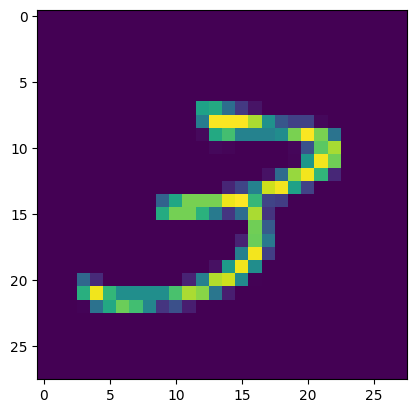

In [7]:
img, label = train_dataset[100]
plt.imshow(img[0])
print(label)

# 各種パラメータ設定

In [8]:
EPOCHS = 10
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
cpus = multiprocessing.cpu_count()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# データローダーの定義

## train, testデータローダを定義

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = cpus)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = TEST_BATCH_SIZE, shuffle = False, num_workers = cpus)

## 確認

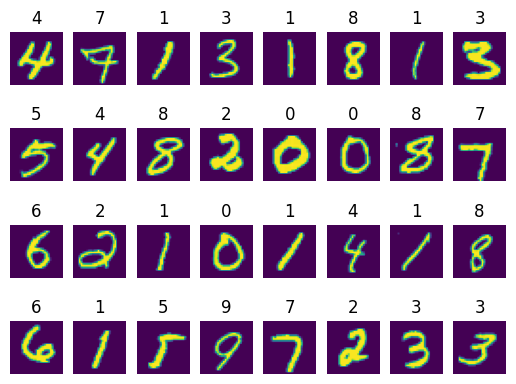

In [10]:
Iter = iter(train_loader)
imgs, labels = next(Iter)

fix, ax = plt.subplots(4, 8)
for i in range(4):
  for j in range(8):
    ax[i, j].imshow(imgs[i*8+j][0])
    ax[i, j].set_title(int(labels[i*8+j]))
    ax[i, j].axis('off')
plt.show()

# 学習ループ

In [11]:
model = timm.create_model("resnet18", pretrained = False, num_classes = 10, in_chans = 1)
model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [12]:
best_loss = 10**18

for epoch in range (EPOCHS) :
  train_loss = 0
  train_cnt = 0
  model.train()
  print(f"EPOCH{epoch}")
  print("[Train]")
  for imgs, labels in tqdm(train_loader) :
    optimizer.zero_grad()
    output = model(imgs.to(device))
    loss = F.cross_entropy(output, labels.to(device))
    loss.backward()
    train_loss += loss.cpu().detach().numpy()
    train_cnt += 1
    optimizer.step()

  valid_loss = 0
  valid_cnt = 0
  model.eval()
  print("[Valid]")
  for imgs, labels in tqdm(test_loader) :
    with torch.no_grad() :
      output = model(imgs.to(device))
    loss = F.cross_entropy(output, labels.to(device))
    valid_loss += loss.cpu().detach().numpy()
    valid_cnt += 1

  if valid_loss < best_loss :
    best_loss = valid_loss
    torch.save(model.state_dict(), "best.pt")

  print("[Score]")
  print(f"train_loss: {train_loss/train_cnt} valid_loss: {valid_loss/valid_cnt}")

EPOCH0
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.13357347518783064 valid_loss: 0.05356866100501007
EPOCH1
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.06477676446094799 valid_loss: 0.04844991985884028
EPOCH2
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.04953372935598406 valid_loss: 0.03458023439208436
EPOCH3
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.040220290688603805 valid_loss: 0.035134751650059096
EPOCH4
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.032409730798465895 valid_loss: 0.03293794722721883
EPOCH5
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.029121986046439268 valid_loss: 0.028766362084575222
EPOCH6
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.023118014719990122 valid_loss: 0.0331843683784965
EPOCH7
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.021007114028999543 valid_loss: 0.02807262489559812
EPOCH8
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.018898928458432298 valid_loss: 0.02624356047834418
EPOCH9
[Train]


  0%|          | 0/1875 [00:00<?, ?it/s]

[Valid]


  0%|          | 0/313 [00:00<?, ?it/s]

[Score]
train_loss: 0.01693798508109321 valid_loss: 0.025676886290853327


# 推論

In [13]:
y_pred = []
y_true = []

model.load_state_dict(torch.load("best.pt"))
model.eval()

for imgs, labels in tqdm(test_loader) :
  with torch.no_grad() :
    output = model(imgs.to(device))
  y_pred += (torch.argmax(output, axis=1).tolist())
  y_true += labels.tolist()

  0%|          | 0/313 [00:00<?, ?it/s]

## 結果の評価

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

cm = confusion_matrix(y_true, y_pred)
for e in cm :
  print(e)

[977   0   0   0   0   0   1   1   1   0]
[   0 1131    0    1    0    0    1    1    1    0]
[   1    2 1023    1    0    0    1    3    1    0]
[   0    0    0 1006    0    3    0    0    1    0]
[  0   0   0   0 977   0   1   0   1   3]
[  1   0   0   3   0 887   1   0   0   0]
[  4   4   0   0   1   1 946   0   2   0]
[   0    4    2    0    1    0    0 1019    1    1]
[  1   0   3   1   0   1   0   1 967   0]
[  0   2   0   1   6   4   0   2  11 983]


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

